In [3]:
# Import custom helper libraries
import os
import sys

# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# System modules
import time
import random
import requests
from hashlib import md5
import json


# ML modules
import pandas as pd
import numpy as np
import seaborn as sns

from utils import *

import string

# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 20 * 1000  # <= 0 for all

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
def reduce_dataframe_memory_usage(df, high_precision = False):
    """
    Iterate through all the columns of a dataframe and modify the data type to
    reduce memory usage.
    Args:
        df (pd.DataFrame): dataframe to reduce memory usage.
        high_precision (bool): If True, use 64-bit floats instead of 32-bit
    Returns:
        pd.DataFrame: dataframe with reduced memory usage.
    """
    start_mem = round(df.memory_usage().sum() / 1024 ** 2, 2)
    logging.info("Memory usage of dataframe is %d MB", start_mem)

    # Iterate through columns
    for col in df.columns:
        if df[col].dtype == "object":
            # "object" dtype
            if df[col].nunique() < max(100, df.shape[0] / 100):
                # If number of unique values is less than max(100, 1%)
                df[col] = df[col].astype("category")
            else:
                # If number of unique values is greater than max(100, 1%)
                df[col] = df[col].astype("string")

        elif str(df[col].dtype)[:3] == "int":
            # "int" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df[col] = df[col].astype("UInt8")
            elif c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype("Int8")
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df[col] = df[col].astype("UInt16")
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype("Int16")
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df[col] = df[col].astype("UInt32")
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype("Int32")
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                df[col] = df[col].astype("UInt64")
            else:
                df[col] = df[col].astype("Int64")

        elif str(df[col].dtype)[:5] == "float":
            # "float" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if (
                not high_precision
                and c_min > np.finfo(np.float32).min
                and c_max < np.finfo(np.float32).max
            ):
                df[col] = df[col].astype("float32")
            else:
                df[col] = df[col].astype("float64")

    end_mem = round(df.memory_usage().sum() / 1024 ** 2, 2)
    logging.info("Memory usage after optimization is %d MB", end_mem)
    if start_mem > 0:
        logging.info(
            "Decreased by %d %%", round(100 * (start_mem - end_mem) / start_mem)
        )

    return df

# Photos dataset

In [8]:
photos_df = pd.DataFrame()
with pd.read_json("data/yelp_photos/photos.json",
    chunksize=500 * 1000,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_df = photos_df.append(chunk)
        logger.info(f"Loaded {len(photos_df)} photos")
logger.info(f">>> OK : {len(photos_df)} photos loaded from JSON file.")

# Reduce memory usage
photos_df = reduce_dataframe_memory_usage(photos_df)

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1474923334.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  photos_df = photos_df.append(chunk)
INFO:__main__:Loaded 200100 photos
INFO:__main__:>>> OK : 200100 photos loaded from JSON file.
INFO:root:Memory usage of dataframe is 6 MB
INFO:root:Memory usage after optimization is 4 MB
INFO:root:Decreased by 22 %


In [9]:
if PHOTO_SAMPLE_SIZE > 0:
    sampled_photos_df = pd.DataFrame()
    for label in photos_df.label.unique():
        sampled_photos_df = sampled_photos_df.append(
            photos_df[photos_df.label == label].sample(
                int(PHOTO_SAMPLE_SIZE / (len(photos_df.label.unique()))),
                random_state=0, replace=True
            )
        )
else:
    sampled_photos_df = photos_df

sampled_photos_df.describe(include="all")

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_photos_df = sampled_photos_df.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_photos_df = sampled_photos_df.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_photos_df = sampled_photos_df.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,photo_id,business_id,caption,label
count,20000,20000,20000,20000
unique,16421,10465,6723,5
top,VISAuSLU8kB79k4wBgj4kA,FEXhWNCMkv22qG04E83Qjg,,drink
freq,11,61,10404,4000


In [10]:
photos_df.shape

(200100, 4)

In [11]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


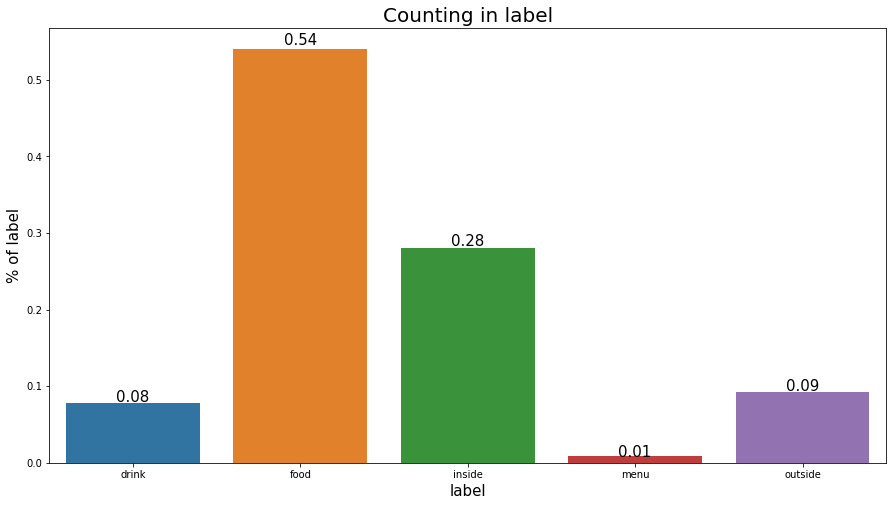

In [12]:
plot_count_col(photos_df, col='label', label_col='label', show_val = True, on_x=True)

In [13]:
drink = photos_df[photos_df.label=='drink'].iloc[:200]
food = photos_df[photos_df.label=='food'].iloc[:200]
inside = photos_df[photos_df.label=='inside'].iloc[:200]
menu = photos_df[photos_df.label=='menu'].iloc[:200]
outside = photos_df[photos_df.label=='outside'].iloc[:200]
df_photos = pd.concat([drink, food, inside, menu, outside], sort=False).reset_index(drop=True)
del drink, food, inside, menu, outside

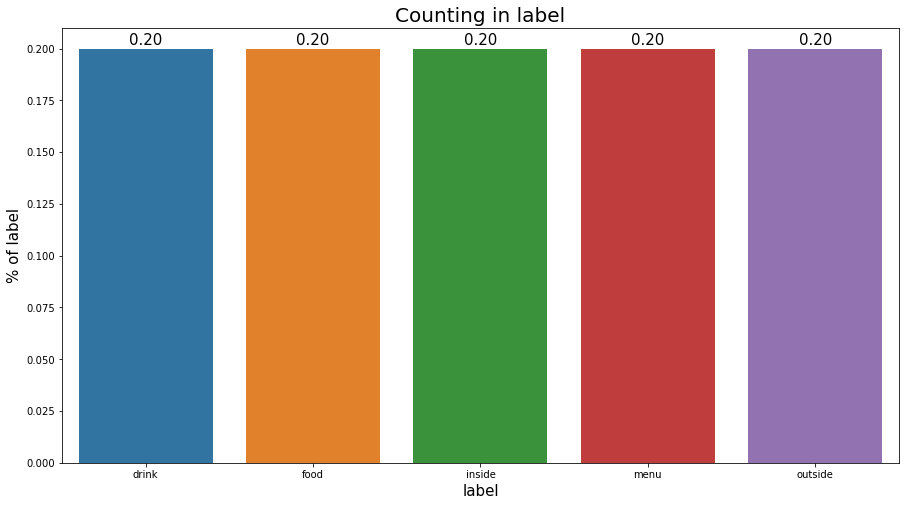

In [14]:
plot_count_col(df_photos, col='label', label_col='label', show_val = True, on_x=True)

Let us know see some examples of images from each category.

In [15]:
import cv2 as cv
from skimage.feature import hog
from sklearn.feature_extraction.image import extract_patches_2d

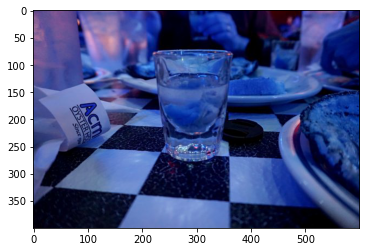

In [26]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='drink'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.imshow(img)
plt.show()

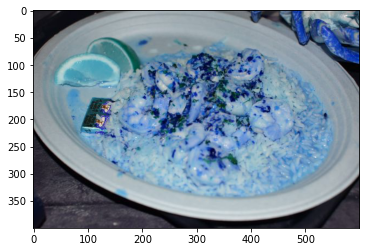

In [24]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='food'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.imshow(img)
plt.show()

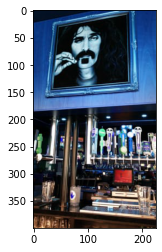

In [21]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='inside'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.imshow(img)
plt.show()

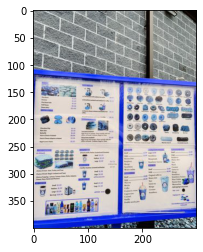

In [22]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='menu'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.imshow(img)
plt.show()

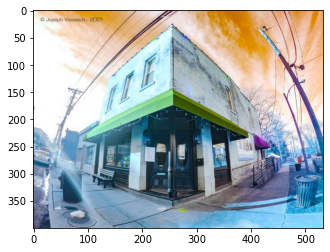

In [23]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='outside'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.imshow(img)
plt.show()

In [25]:
img.shape

(400, 600, 3)

In this part of project we are predicting the label of the photos. But before this we need to proceed the extraction of the features in our images datasets. 
We will use the ORB (Oriented FAST and Rotated BRIEF) features.

# Visual features extraction
 - compute the 200 first ORB keypoints of the image. We obtain 200 vectors of size 32 per image

In [108]:
df_photos_features = pd.DataFrame()

for photo in df_photos.itertuples():
    # Load image
    img_path = 'data/yelp_photos/photos/{0}.jpg'.format(photo.photo_id)
    
    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # ORB Features
    orb = cv.ORB_create(nfeatures=200)
    orb_keypoints = orb.detect(img_gray, None)
    orb_keypoints, orb_descriptors = orb.compute(img_gray, orb_keypoints)
    
    # create SIFT object
    sift = cv.xfeatures2d.SIFT_create(nfeatures=200)
    sift_keypoints = sift.detect(img_gray, None)
    sift_keypoints, sift_descriptors = sift.compute(img_gray, sift_keypoints)

    dict_to_add = {"file_name": photo.photo_id, "label": photo.label, "orb_keypoints": orb_keypoints, "orb_descriptors": orb_descriptors, "sift_keypoints": sift_keypoints, "sift_descriptors": sift_descriptors}
    df_photos_features = df_photos_features.append(
        dict_to_add,
        ignore_index=True,
    )

df_photos_features.dropna(inplace=True)

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1343703141.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_photos_features = df_photos_features.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1343703141.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_photos_features = df_photos_features.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1343703141.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_photos_features = df_photos_features.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/1343703141.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [109]:
df_photos_features

,file_name,label,orb_keypoints,orb_descriptors,sift_keypoints,sift_descriptors
0,vkr8T0scuJmGVvN2HJelEA,drink,"(< cv2.KeyPoint 0x15ebc0870>, < cv2.KeyPoint 0...","[[215, 28, 239, 7, 18, 62, 234, 48, 237, 226, ...","(< cv2.KeyPoint 0x15bd21e70>, < cv2.KeyPoint 0...","[[20.0, 17.0, 6.0, 2.0, 25.0, 61.0, 8.0, 9.0, ..."
1,VYP7IZ8SjyRLM1II5WcKew,drink,"(< cv2.KeyPoint 0x15f7a4660>, < cv2.KeyPoint 0...","[[184, 215, 28, 250, 57, 137, 83, 188, 151, 20...","(< cv2.KeyPoint 0x15f7a1c60>, < cv2.KeyPoint 0...","[[32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 88..."
2,pRnGI7xv7ZBJ8p_w0xy9fg,drink,"(< cv2.KeyPoint 0x1648ec4b0>, < cv2.KeyPoint 0...","[[53, 141, 43, 238, 213, 246, 238, 104, 84, 64...","(< cv2.KeyPoint 0x1648d9ab0>, < cv2.KeyPoint 0...","[[14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 22.0, 13..."
3,Iehiw_bcHnXw-pg0w2M06w,drink,"(< cv2.KeyPoint 0x1648e6300>, < cv2.KeyPoint 0...","[[6, 236, 51, 208, 87, 153, 175, 235, 254, 151...","(< cv2.KeyPoint 0x1648ee900>, < cv2.KeyPoint 0...","[[9.0, 1.0, 7.0, 13.0, 4.0, 1.0, 48.0, 80.0, 1..."
4,1q1aIcuJMdeTt8QEyXFIeQ,drink,"(< cv2.KeyPoint 0x1648f9fc0>, < cv2.KeyPoint 0...","[[120, 184, 188, 242, 169, 253, 93, 191, 171, ...","(< cv2.KeyPoint 0x164905600>, < cv2.KeyPoint 0...","[[32.0, 22.0, 3.0, 5.0, 0.0, 0.0, 0.0, 0.0, 16..."
...,...,...,...,...,...,...
995,KNbz5zsstJPTJPFv1mHB7A,outside,"(< cv2.KeyPoint 0x16c58c750>, < cv2.KeyPoint 0...","[[109, 164, 136, 156, 29, 71, 66, 43, 82, 235,...","(< cv2.KeyPoint 0x16c58fdb0>, < cv2.KeyPoint 0...","[[44.0, 24.0, 16.0, 13.0, 43.0, 16.0, 38.0, 10..."
996,I8MB8apJpblh_im2RwlYqQ,outside,"(< cv2.KeyPoint 0x16c55fed0>, < cv2.KeyPoint 0...","[[241, 49, 27, 40, 73, 197, 16, 65, 237, 72, 2...","(< cv2.KeyPoint 0x16c57c6f0>, < cv2.KeyPoint 0...","[[17.0, 8.0, 11.0, 15.0, 14.0, 20.0, 23.0, 12...."
997,IvVt3OjgZ3fNhpMvxQ18DQ,outside,"(< cv2.KeyPoint 0x16c570f00>, < cv2.KeyPoint 0...","[[8, 81, 19, 239, 171, 76, 172, 85, 164, 128, ...","(< cv2.KeyPoint 0x16c582570>, < cv2.KeyPoint 0...","[[5.0, 0.0, 0.0, 13.0, 140.0, 0.0, 0.0, 4.0, 5..."
998,IhfNzqhFHW35S5NtxpMvxg,outside,"(< cv2.KeyPoint 0x16c595d80>, < cv2.KeyPoint 0...","[[104, 152, 181, 249, 13, 237, 80, 15, 159, 55...","(< cv2.KeyPoint 0x16c5983f0>, < cv2.KeyPoint 0...","[[11.0, 0.0, 1.0, 58.0, 29.0, 1.0, 0.0, 25.0, ..."


## SIFT features
Now we use the SIFT features to group different keypoints detected from the SIFT algorithm. We start by creation of our dataset of SIFT features.

In [111]:
sift_features = np.array([
    descriptor for photo_sift_feature in df_photos_features["sift_descriptors"] for descriptor in photo_sift_feature
])
sift_features.shape

(198783, 128)

In [112]:
sift_features

array([[ 20.,  17.,   6., ...,  12.,   0.,   0.],
       [126.,  22.,   0., ...,   2.,   0.,   1.],
       [ 39.,   0.,   0., ...,  11.,   0.,   0.],
       ...,
       [ 90.,   5.,   6., ...,  21.,  60.,  38.],
       [ 34.,   0.,   0., ...,   0.,   0.,   0.],
       [ 42.,   2.,   0., ..., 115.,   0.,   0.]], dtype=float32)

Scalling the sift features

In [114]:
from sklearn.preprocessing import StandardScaler


sift_scaler = StandardScaler().fit(sift_features)
sift_features_std = sift_scaler.transform(sift_features)

We use the Elbow method to define the number of clusters

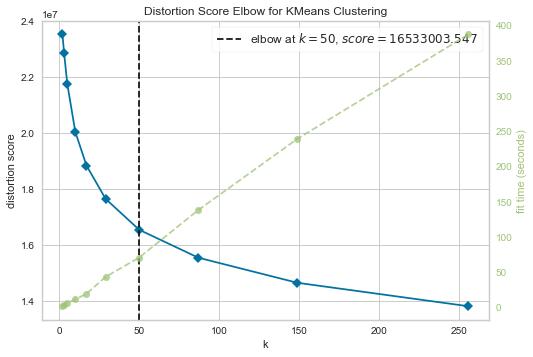

In [117]:
# Instantiate the clustering model and visualizer 
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans
# Instantiate the clustering model and visualizer
model = KMeans(random_state=10, init='k-means++')
visualizer = KElbowVisualizer(model, k=np.logspace(start=1, stop=8, base=2, num=10, dtype=int))

vis = visualizer.fit(sift_features_std);    # Fit the data to the visualizer

visualizer.poof();    # Draw/show/poof the data

Bag of visual-words representing the photo: Now we train our clustering model and count the number of occurrences of each SIFT cluster for each photo.

In [123]:
from sklearn.cluster import KMeans


K = 50
sift_kmeans = KMeans(n_clusters=K, random_state=10).fit(sift_features_std)

df_photos_features["sift_clusters"] = [
    sift_kmeans.predict(sift_scaler.transform(desc))
    for desc in df_photos_features["sift_descriptors"]
]

for cluster in range(K):
    df_photos_features[f"sift_cluster_{cluster}"] = 0

    for i, photo in df_photos_features.iterrows():
        df_photos_features.loc[i, f"sift_cluster_{cluster}"] = list(
            df_photos_features.loc[i, "sift_clusters"]
        ).count(cluster)

df_photos_features[
    ["sift_clusters"] + [f"sift_cluster_{i}" for i in range(K)]
].head(5)



,sift_clusters,sift_cluster_0,sift_cluster_1,sift_cluster_2,sift_cluster_3,sift_cluster_4,sift_cluster_5,sift_cluster_6,sift_cluster_7,sift_cluster_8,...,sift_cluster_40,sift_cluster_41,sift_cluster_42,sift_cluster_43,sift_cluster_44,sift_cluster_45,sift_cluster_46,sift_cluster_47,sift_cluster_48,sift_cluster_49
0,"[20, 2, 20, 22, 47, 39, 49, 43, 43, 5, 43, 0, ...",4,0,1,2,2,5,4,2,5,...,1,5,8,6,2,4,2,5,7,4
1,"[2, 48, 15, 45, 37, 25, 2, 2, 2, 6, 22, 2, 2, ...",2,1,29,0,2,1,3,2,16,...,1,4,1,3,4,3,1,2,5,3
2,"[5, 45, 32, 41, 41, 40, 30, 14, 49, 10, 19, 43...",9,1,0,2,2,13,9,7,9,...,6,4,2,8,1,5,1,3,6,4
3,"[24, 3, 1, 16, 3, 29, 27, 13, 27, 0, 24, 29, 4...",8,9,4,11,2,1,1,2,6,...,3,3,1,4,0,0,1,5,1,7
4,"[14, 9, 37, 4, 23, 45, 14, 38, 39, 31, 38, 14,...",6,0,1,1,3,27,3,2,6,...,3,5,2,2,1,1,0,4,1,5


## ORB features

Now we use the ORB features to group different keypoints detected from the ORB algorithm. We start by creation of our dataset of ORB features.

In [78]:
orb_features = np.array([
    descriptor for photo_orb_feature in df_photos_features["orb_descriptors"] for descriptor in photo_orb_feature
])
orb_features.shape

(198515, 32)

In [79]:
orb_features

array([[215,  28, 239, ..., 227,  41,  52],
       [249,  92,  19, ...,  17,  42,  28],
       [103,  72, 236, ..., 184,  92,  84],
       ...,
       [124, 200, 150, ..., 125, 124, 142],
       [ 29, 105, 240, ..., 183,  79, 162],
       [ 58,  20, 182, ...,  76,  61, 251]], dtype=uint8)

Scalling the orb features

In [82]:
from sklearn.preprocessing import StandardScaler


orb_scaler = StandardScaler().fit(orb_features)
orb_features_std = orb_scaler.transform(orb_features)

We use the Elbow method to define the number of clusters

In [83]:
# Instantiate the clustering model and visualizer 
from yellowbrick.cluster import KElbowVisualizer

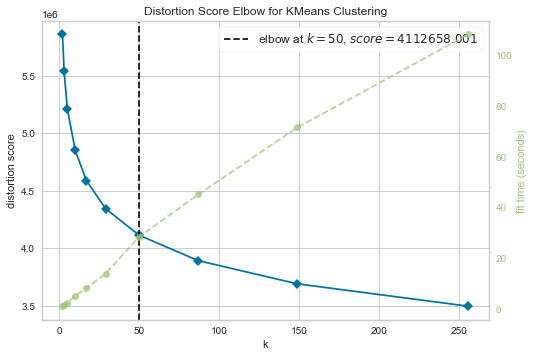

In [93]:
from sklearn.cluster import KMeans
# Instantiate the clustering model and visualizer
model = KMeans(random_state=10, init='k-means++')
visualizer = KElbowVisualizer(model, k=np.logspace(start=1, stop=8, base=2, num=10, dtype=int))

vis = visualizer.fit(orb_features_std);    # Fit the data to the visualizer

visualizer.poof();    # Draw/show/poof the data

Bag of visual-words representing the photo:
Now we train our clustering model and count the number of occurrences of each ORB cluster for each photo. 

In [124]:
from sklearn.cluster import KMeans


K = 50
orb_kmeans = KMeans(n_clusters=K, random_state=10).fit(orb_features_std)

df_photos_features["orb_clusters"] = [
    orb_kmeans.predict(orb_scaler.transform(desc))
    for desc in df_photos_features["orb_descriptors"]
]

for cluster in range(K):
    df_photos_features[f"orb_cluster_{cluster}"] = 0

    for i, photo in df_photos_features.iterrows():
        df_photos_features.loc[i, f"orb_cluster_{cluster}"] = list(
            df_photos_features.loc[i, "orb_clusters"]
        ).count(cluster)

df_photos_features[
    ["orb_clusters"] + [f"orb_cluster_{i}" for i in range(K)]
].head(5)

,orb_clusters,orb_cluster_0,orb_cluster_1,orb_cluster_2,orb_cluster_3,orb_cluster_4,orb_cluster_5,orb_cluster_6,orb_cluster_7,orb_cluster_8,...,orb_cluster_40,orb_cluster_41,orb_cluster_42,orb_cluster_43,orb_cluster_44,orb_cluster_45,orb_cluster_46,orb_cluster_47,orb_cluster_48,orb_cluster_49
0,"[31, 45, 31, 0, 5, 29, 47, 39, 24, 40, 29, 34,...",6,2,6,5,7,7,0,1,1,...,4,2,5,5,8,1,4,6,3,0
1,"[48, 35, 47, 21, 9, 31, 0, 14, 37, 16, 1, 14, ...",5,4,3,2,1,7,4,0,13,...,5,5,0,6,5,1,3,4,2,4
2,"[22, 1, 20, 7, 0, 9, 2, 23, 6, 39, 5, 42, 8, 3...",11,7,10,3,3,5,5,2,7,...,2,6,3,9,4,3,2,2,1,6
3,"[28, 8, 11, 5, 38, 7, 32, 43, 25, 0, 7, 24, 11...",3,2,2,6,5,4,2,8,4,...,5,2,5,5,5,3,4,3,5,2
4,"[2, 28, 13, 8, 13, 13, 30, 19, 37, 44, 16, 42,...",0,4,3,0,2,2,10,4,10,...,4,5,3,4,5,2,1,9,8,8


Bag of visual-words representing will be used next in the classification task.

# Image classification

In [125]:
df_photos_features.head()

,file_name,label,orb_keypoints,orb_descriptors,sift_keypoints,sift_descriptors,sift_clusters,sift_cluster_0,sift_cluster_1,sift_cluster_2,...,orb_cluster_40,orb_cluster_41,orb_cluster_42,orb_cluster_43,orb_cluster_44,orb_cluster_45,orb_cluster_46,orb_cluster_47,orb_cluster_48,orb_cluster_49
0,vkr8T0scuJmGVvN2HJelEA,drink,"(< cv2.KeyPoint 0x15ebc0870>, < cv2.KeyPoint 0...","[[215, 28, 239, 7, 18, 62, 234, 48, 237, 226, ...","(< cv2.KeyPoint 0x15bd21e70>, < cv2.KeyPoint 0...","[[20.0, 17.0, 6.0, 2.0, 25.0, 61.0, 8.0, 9.0, ...","[20, 2, 20, 22, 47, 39, 49, 43, 43, 5, 43, 0, ...",4,0,1,...,4,2,5,5,8,1,4,6,3,0
1,VYP7IZ8SjyRLM1II5WcKew,drink,"(< cv2.KeyPoint 0x15f7a4660>, < cv2.KeyPoint 0...","[[184, 215, 28, 250, 57, 137, 83, 188, 151, 20...","(< cv2.KeyPoint 0x15f7a1c60>, < cv2.KeyPoint 0...","[[32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 88...","[2, 48, 15, 45, 37, 25, 2, 2, 2, 6, 22, 2, 2, ...",2,1,29,...,5,5,0,6,5,1,3,4,2,4
2,pRnGI7xv7ZBJ8p_w0xy9fg,drink,"(< cv2.KeyPoint 0x1648ec4b0>, < cv2.KeyPoint 0...","[[53, 141, 43, 238, 213, 246, 238, 104, 84, 64...","(< cv2.KeyPoint 0x1648d9ab0>, < cv2.KeyPoint 0...","[[14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 22.0, 13...","[5, 45, 32, 41, 41, 40, 30, 14, 49, 10, 19, 43...",9,1,0,...,2,6,3,9,4,3,2,2,1,6
3,Iehiw_bcHnXw-pg0w2M06w,drink,"(< cv2.KeyPoint 0x1648e6300>, < cv2.KeyPoint 0...","[[6, 236, 51, 208, 87, 153, 175, 235, 254, 151...","(< cv2.KeyPoint 0x1648ee900>, < cv2.KeyPoint 0...","[[9.0, 1.0, 7.0, 13.0, 4.0, 1.0, 48.0, 80.0, 1...","[24, 3, 1, 16, 3, 29, 27, 13, 27, 0, 24, 29, 4...",8,9,4,...,5,2,5,5,5,3,4,3,5,2
4,1q1aIcuJMdeTt8QEyXFIeQ,drink,"(< cv2.KeyPoint 0x1648f9fc0>, < cv2.KeyPoint 0...","[[120, 184, 188, 242, 169, 253, 93, 191, 171, ...","(< cv2.KeyPoint 0x164905600>, < cv2.KeyPoint 0...","[[32.0, 22.0, 3.0, 5.0, 0.0, 0.0, 0.0, 0.0, 16...","[14, 9, 37, 4, 23, 45, 14, 38, 39, 31, 38, 14,...",6,0,1,...,4,5,3,4,5,2,1,9,8,8


In [126]:
from sklearn.model_selection import train_test_split

K= 50

X = df_photos_features[
    [f"sift_cluster_{cluster}" for cluster in range(K)]+
    [f"orb_cluster_{cluster}" for cluster in range(K)]
                      ]
y = df_photos_features.label


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=1,
)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [127]:
X

,sift_cluster_0,sift_cluster_1,sift_cluster_2,sift_cluster_3,sift_cluster_4,sift_cluster_5,sift_cluster_6,sift_cluster_7,sift_cluster_8,sift_cluster_9,...,orb_cluster_40,orb_cluster_41,orb_cluster_42,orb_cluster_43,orb_cluster_44,orb_cluster_45,orb_cluster_46,orb_cluster_47,orb_cluster_48,orb_cluster_49
0,4,0,1,2,2,5,4,2,5,4,...,4,2,5,5,8,1,4,6,3,0
1,2,1,29,0,2,1,3,2,16,7,...,5,5,0,6,5,1,3,4,2,4
2,9,1,0,2,2,13,9,7,9,11,...,2,6,3,9,4,3,2,2,1,6
3,8,9,4,11,2,1,1,2,6,0,...,5,2,5,5,5,3,4,3,5,2
4,6,0,1,1,3,27,3,2,6,10,...,4,5,3,4,5,2,1,9,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,4,1,2,4,0,6,6,8,5,...,4,2,3,2,5,2,5,1,9,1
996,5,4,2,2,6,2,7,4,6,3,...,5,0,4,5,3,3,4,2,13,4
997,9,0,0,4,5,5,3,5,2,7,...,6,1,6,8,0,6,2,0,7,3
998,2,1,4,0,4,1,6,6,1,3,...,1,2,10,4,7,2,5,10,8,0


In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_train) 

X_std = scaler.transform(X)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [184]:
X_train_std.shape[1]

100

In [185]:
from sklearn.decomposition import PCA
pca_features_ratio = {}
explained_by_pca = 0.99
is_not_selected=True

pca = PCA(random_state=10)
pca.fit(X_train_std)
for k in range(X_train_std.shape[1]):
    s = np.cumsum(pca.explained_variance_ratio_)[k]
    pca_features_ratio[k] = s
    if ((s>=explained_by_pca) & is_not_selected):
        n_comp = k
        is_not_selected = False

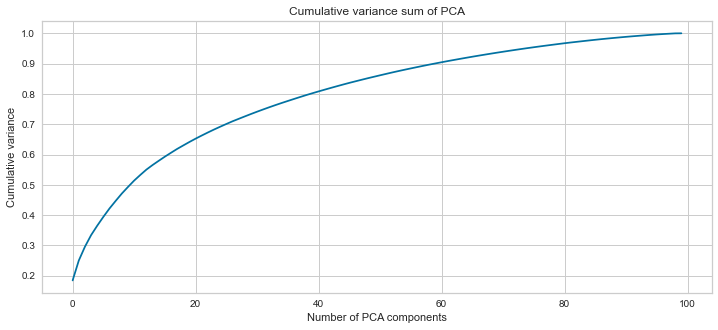

In [186]:
plt.figure(figsize=(12,5));
plt.title('Cumulative variance sum of PCA');
plt.xlabel('Number of PCA components');
plt.ylabel('Cumulative variance');
plt.plot(list(range(X_train_std.shape[1])),
np.cumsum(pca.explained_variance_ratio_), '-x');

In [187]:
n_comp

91

In [195]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=n_comp, random_state=10)
pca.fit(X_train_std)

X_train_projected = pca.transform(X_train_std)
X_train_projected = pd.DataFrame(X_train_projected, columns = ['F{0}'.format(i) for i in range(n_comp)])

X_test_projected = pca.transform(X_test_std)
X_test_projected = pd.DataFrame(X_test_projected, columns = ['F{0}'.format(i) for i in range(n_comp)])

X_train_projected.loc[:,'label'] = y_train
#X_test_projected.loc[:,'label'] = y_test

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_65713/3093916965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.loc[:,'label'] = y_train


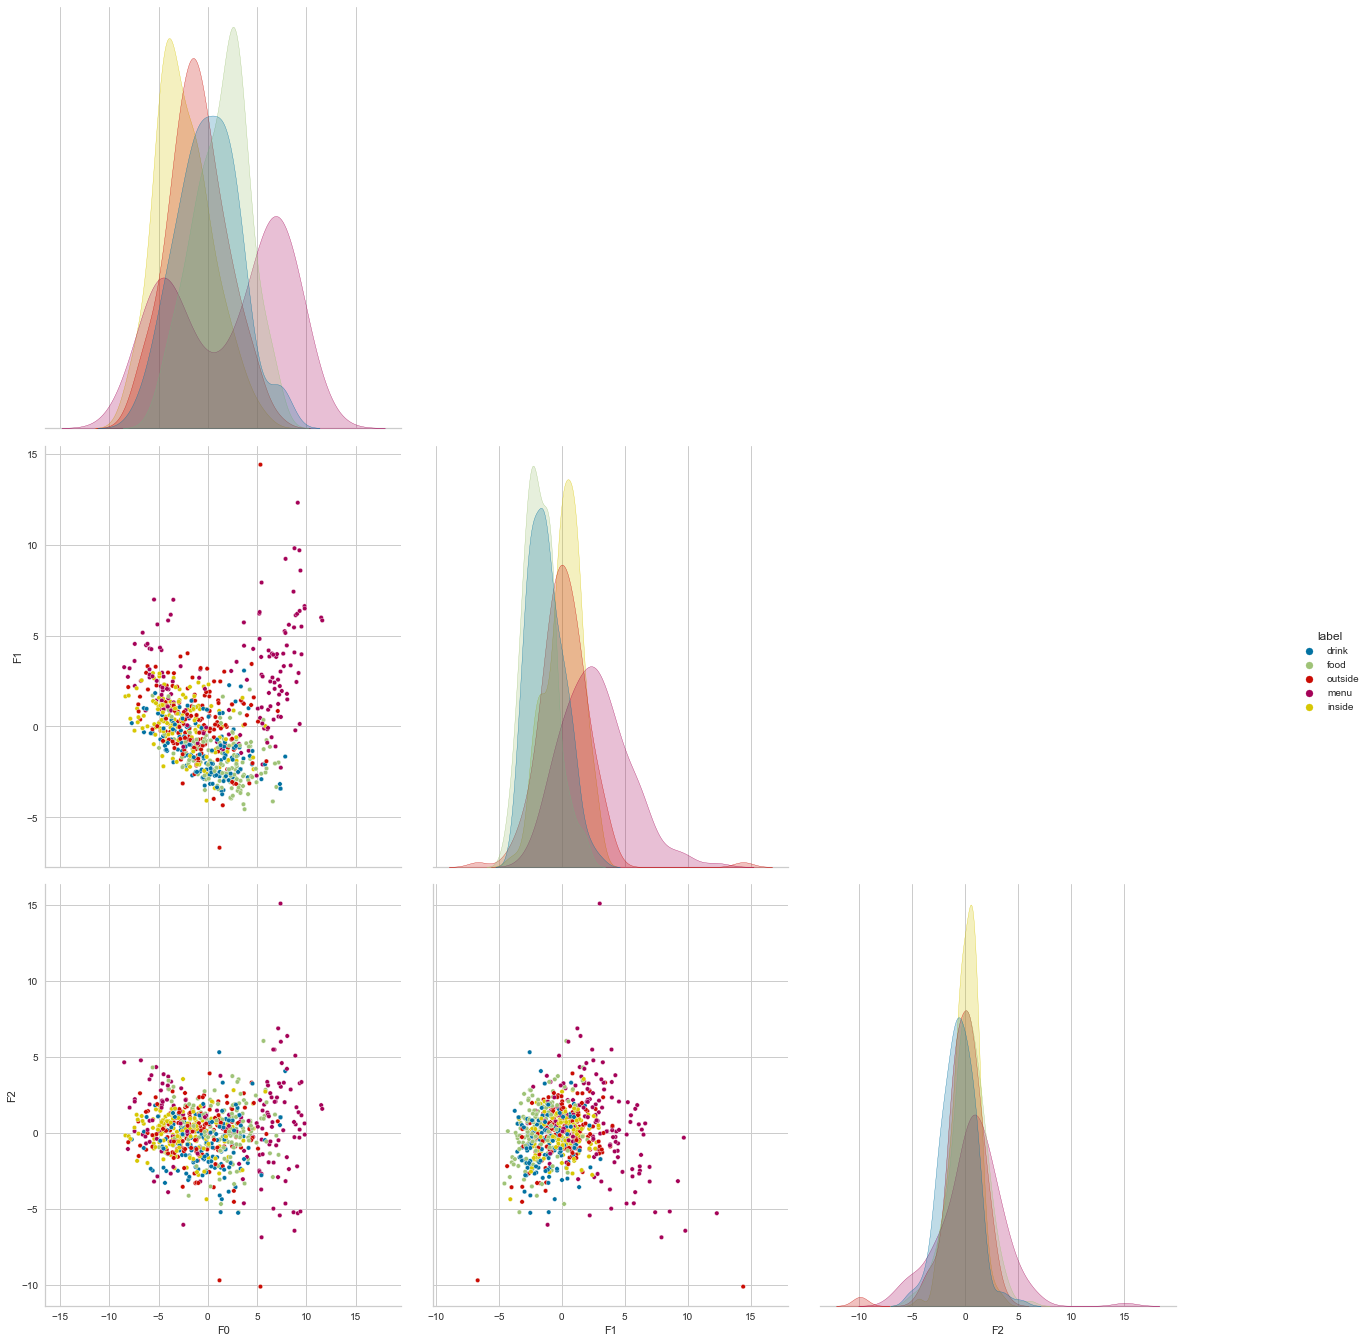

In [196]:
N = 3
to_plot = X_train_projected.iloc[: , :N]
to_plot.loc[:,'label'] = y_train
g=sns.pairplot(to_plot, plot_kws = {'s': 20}, corner=True, hue='label')
g.fig.set_size_inches(20,20)
del to_plot
X_train_projected = X_train_projected.drop(columns=['label'])

In [203]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
T_train = tsne.fit_transform(X_train)
T_train = pd.DataFrame(T_train, columns=['T1', 'T2'])

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [204]:
T_train.loc[:,'label'] = y_train

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


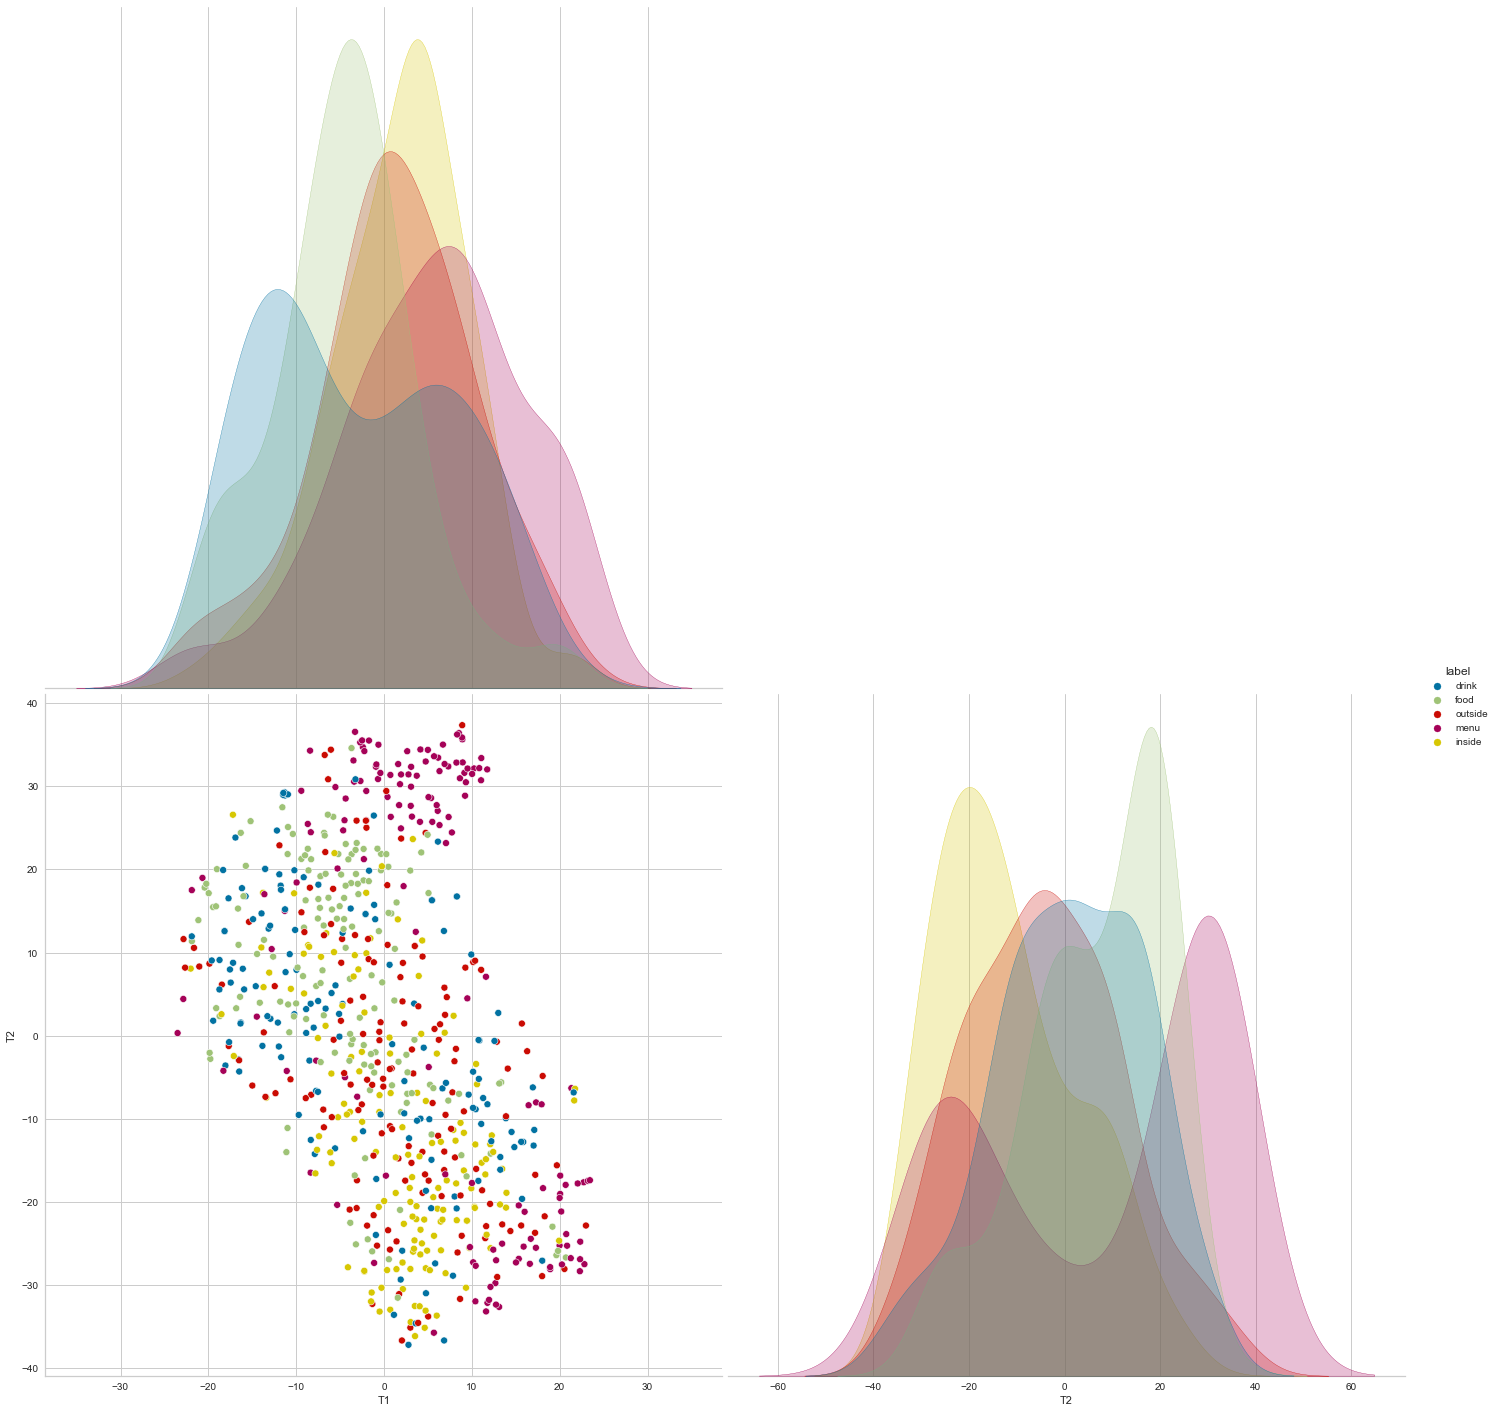

In [205]:
sns.pairplot(T_train, size=10, corner=True, hue='label')

In [200]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_jobs=-1).fit(X_train_projected, y_train)

y_train_pred = knn.predict(X_train_projected)
y_test_pred = knn.predict(X_test_projected)

In [201]:
from sklearn.metrics import plot_confusion_matrix, classification_report


print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       drink       0.64      0.70      0.67       150
        food       0.68      0.73      0.70       150
      inside       0.49      0.69      0.57       150
        menu       0.89      0.68      0.77       150
     outside       0.68      0.46      0.55       150

    accuracy                           0.65       750
   macro avg       0.68      0.65      0.65       750
weighted avg       0.68      0.65      0.65       750



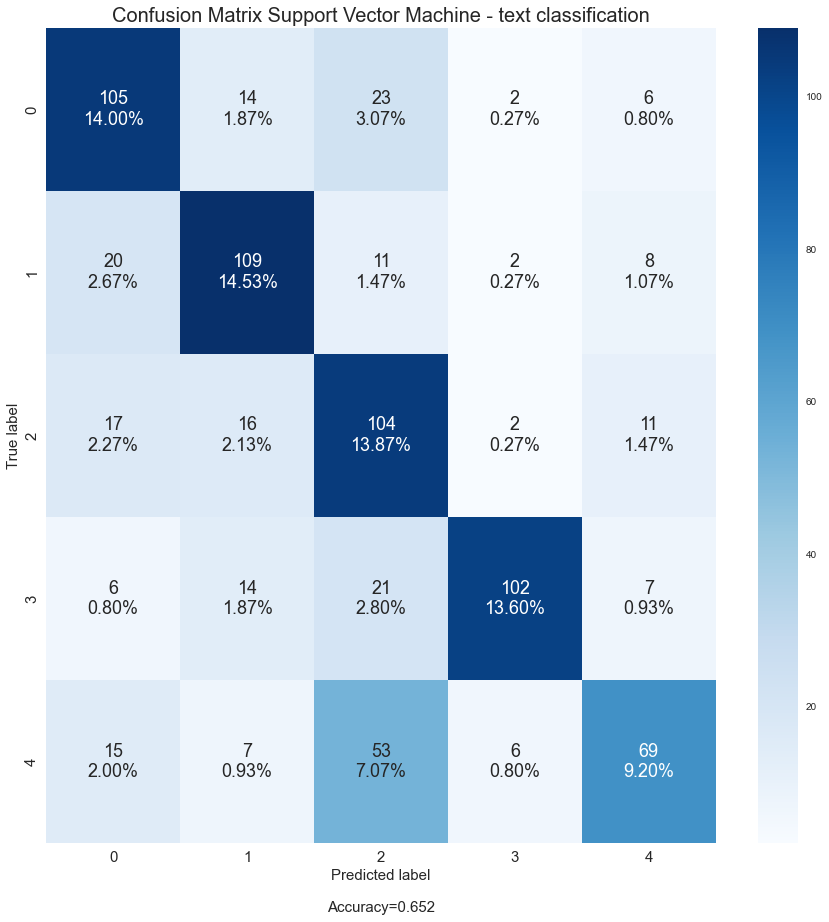

In [202]:
make_confusion_matrix(confusion_matrix(y_train, y_train_pred), figsize=(15, 15), title='Confusion Matrix Support Vector Machine - text classification')